In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download(['stopwords','punkt','wordnet','omw-1.4','vader_lexicon'])
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data Preparation

In [2]:
# Loading the data
reviews = pd.read_csv("tourist_accommodation_reviews.csv")
reviews.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere..."
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...


In [3]:
reviews.shape

(53644, 5)

In [4]:
reviews.describe()

,ID,Review Date,Location,Hotel/Restaurant name,Review
count,53644,53644,53644,53644,53644
unique,49944,2344,25,537,49938
top,rn564592095,Reviewed 1 week ago,Patong,Da Mario,I have been to this restaurant several times f...
freq,10,616,16403,279,10


In [5]:
# Creating a function to apply all of our data preprocessing steps which we can then use on a corpus
stop_words = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

def preprocess_text(text):
  tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text) # Tokenize
  cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words] # Remove stop_words
  stemmed_text = [stemmer.stem(word) for word in cleaned_tokens] # Stemming
  return stemmed_text

In [6]:
# Extracting the polarity_scores and using them to create new columns within our dataframe
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

reviews['compound'] = [sentiment.polarity_scores(review)['compound'] for review in reviews['Review']]
reviews['neg'] = [sentiment.polarity_scores(review)['neg'] for review in reviews['Review']]
reviews['neu'] = [sentiment.polarity_scores(review)['neu'] for review in reviews['Review']]
reviews['pos'] = [sentiment.polarity_scores(review)['pos'] for review in reviews['Review']]

In [7]:
reviews.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...,0.0516,0.11,0.772,0.118
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere...",0.9237,0.00,0.730,0.270
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...,0.6808,0.00,0.869,0.131
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...,0.8419,0.00,0.823,0.177
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...,0.9734,0.00,0.557,0.443


Selecting any 30 hotels/restaurants from the data: This selection is made based on the number of reviews for each hotel/restaurant. The top 30 hotels with the most reviews would be selected.

In [8]:
# To determine the hotels/restaurants and their number of reviews
hotel_reviews_count = reviews['Hotel/Restaurant name'].value_counts()
hotel_reviews_count

Da Mario                                             279
Sabai Sabai                                          200
No.6 Restaurant                                      200
The Pizza Company                                    198
The Family Restaurant                                196
                                                    ... 
Sultan's Grill Authentic Turkish & Indian Cuisine     91
Som Restaurant                                        91
Chez Nicolas                                          90
Dada Yura Restaurant                                  80
Chekhoff Restaurant and Bar                           30
Name: Hotel/Restaurant name, Length: 537, dtype: int64

In [9]:
# Selecting top 30 hotels with the highest number of reviews
selected_hotels = reviews['Hotel/Restaurant name'].value_counts().nlargest(30)
selected_hotels

Da Mario                                                    279
Sabai Sabai                                                 200
No.6 Restaurant                                             200
The Pizza Company                                           198
The Family Restaurant                                       196
Outdoor Restaurant                                          193
Thong Dee The Kathu Brasserie                               100
Joe's Downstairs                                            100
Full Moon Brewworks - Microbrewery & Lobs n' Roll           100
The Coffee Club - The Turtle Village                        100
Da Maurizio Beach Side                                      100
Pizzeria Hut 1                                              100
Don's Bar B Q                                               100
Rum Jungle                                                  100
The Drunken Leprechaun                                      100
Red Snapper                             

In [10]:
# Selecting the reviews for the 30 hotels selected
reviews = reviews.loc[reviews['Hotel/Restaurant name'].isin(selected_hotels.keys())]
reviews.head(10)

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos
0,rn579778340,Reviewed 1 week ago,Kathu,Thong Dee The Kathu Brasserie,Just been for sunday roast lamb and beef truly...,0.0516,0.110,0.772,0.118
1,rn576350875,Reviewed 3 weeks ago,Kathu,Thong Dee The Kathu Brasserie,"Quietly set off the main road, nice atmosphere...",0.9237,0.000,0.730,0.270
2,rn574921678,Reviewed 4 weeks ago,Kathu,Thong Dee The Kathu Brasserie,I made a reservation for a birthday two days i...,0.6808,0.000,0.869,0.131
3,rn572905503,"Reviewed April 12, 2018",Kathu,Thong Dee The Kathu Brasserie,We visit here regularly and never fail to be i...,0.8419,0.000,0.823,0.177
4,rn572364712,"Reviewed April 10, 2018",Kathu,Thong Dee The Kathu Brasserie,Visited this wonderful place on my travels and...,0.9734,0.000,0.557,0.443
5,rn572308369,"Reviewed April 9, 2018",Kathu,Thong Dee The Kathu Brasserie,We travel to Phuket every year from Australia ...,0.9633,0.000,0.650,0.350
6,rn572053040,"Reviewed April 8, 2018",Kathu,Thong Dee The Kathu Brasserie,Had roast beef and lamb plenty of it and very ...,-0.3691,0.116,0.840,0.044
7,rn571915434,"Reviewed April 8, 2018",Kathu,Thong Dee The Kathu Brasserie,This place has a lot to learn when it comes to...,0.8221,0.000,0.823,0.177
8,rn571792182,"Reviewed April 7, 2018",Kathu,Thong Dee The Kathu Brasserie,This restaurant oozes class as soon as you ent...,0.7506,0.000,0.870,0.130
9,rn571778672,"Reviewed April 7, 2018",Kathu,Thong Dee The Kathu Brasserie,"Put simply, just one of the best dining experi...",0.8833,0.021,0.734,0.245


In [11]:
reviews[['compound','neg','neu','pos']].describe()

,compound,neg,neu,pos
count,3666.000000,3666.000000,3666.000000,3666.000000
mean,0.632478,0.028514,0.748560,0.222935
std,0.435057,0.052121,0.124429,0.131763
min,-0.941600,0.000000,0.298000,0.000000
25%,0.526700,0.000000,0.670000,0.127000
50%,0.826550,0.000000,0.752000,0.218000
75%,0.918050,0.046000,0.837000,0.310000
max,0.987200,0.497000,1.000000,0.698000


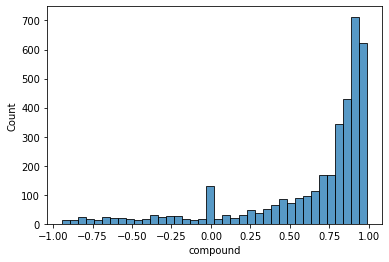

In [12]:
sns.histplot(reviews['compound'])

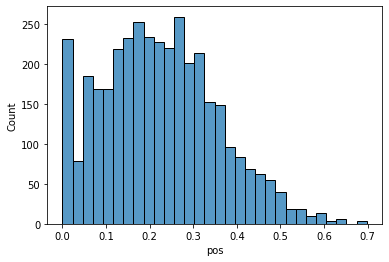

In [13]:
sns.histplot(reviews['pos'])

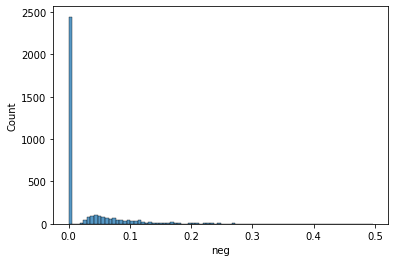

In [14]:
sns.histplot(reviews['neg'])

In [15]:
# To determine the number of negative reviews per hotel/restaurant
(reviews['compound']<=0).groupby(reviews['Hotel/Restaurant name']).sum()

Hotel/Restaurant name
Baan Rim Pa Patong                                           9
Da Mario                                                    49
Da Maurizio Beach Side                                      11
Don's Bar B Q                                               10
Full Moon Brewworks - Microbrewery & Lobs n' Roll           13
Happy Days                                                   9
Harrys Steakhouse & Hotel                                   11
Joe's Downstairs                                             9
Kan Eang@Pier Restaurant                                    13
Louis' Kitchen                                              10
Natural Restaurant                                          20
No.6 Restaurant                                             18
Outdoor Restaurant                                          48
Pizzeria Hut 1                                              15
Red Snapper                                                 21
Red Tuna Restaurant Phuket       

In [16]:
# Calculating the negative reviews as a percentage of total reviews
percent_negative = pd.DataFrame((reviews['compound']<=0).groupby(reviews['Hotel/Restaurant name']).sum()
                                /reviews['Hotel/Restaurant name'].groupby(reviews['Hotel/Restaurant name']).count()*100,
                                columns=['% negative reviews']).sort_values(by='% negative reviews', ascending=False)
percent_negative

,% negative reviews
Hotel/Restaurant name,
Outdoor Restaurant,24.870466
The Pizza Company,22.727273
Red Snapper,21.000000
Natural Restaurant,20.000000
Da Mario,17.562724
Sea Hag Restaurant,17.000000
Pizzeria Hut 1,15.000000
The Coffee Club - The Turtle Village,15.000000
Tawai Thai Restaurant,14.000000


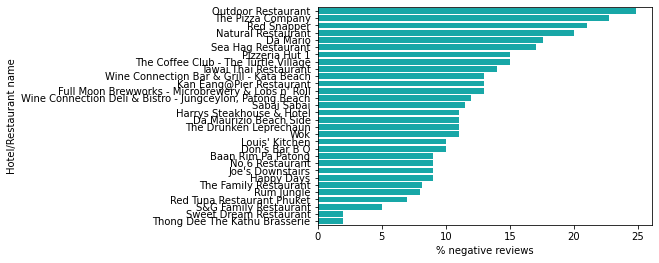

In [17]:
# Plotting the percentage of negative reviews
sns.barplot(data=percent_negative, x='% negative reviews', y=percent_negative.index, color='c')

In [18]:
# Processing the 'Review' for wordcloud visualisation
# 'Da Mario' has the highest number of reviews, hence it would be the focus of this analysis

reviews['processed_review'] = reviews['Review'].apply(preprocess_text)

reviews_positive_subset = reviews.loc[(reviews['Hotel/Restaurant name']=='Da Mario') & (reviews['compound']>0),:]
reviews_negative_subset = reviews.loc[(reviews['Hotel/Restaurant name']=='Da Mario') & (reviews['compound']<=0),:]

In [19]:
reviews_positive_subset.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos,processed_review
29056,rn578544302,Reviewed 1 week ago,Patong,Da Mario,"This is one stop we make every time, looking p...",0.8047,0.032,0.809,0.159,"[one, stop, make, everi, time, look, past, ecl..."
29057,rn570737159,"Reviewed April 3, 2018",Patong,Da Mario,Fantastic food and a great host (Christian) gr...,0.9718,0.000,0.411,0.589,"[fantast, food, great, host, christian, great,..."
29058,rn567056307,"Reviewed March 17, 2018",Patong,Da Mario,My wife and I tried this on spec. It was a nic...,0.8201,0.000,0.816,0.184,"[wife, tri, spec, nice, place, run, italian, f..."
29060,rn558261306,"Reviewed February 4, 2018",Patong,Da Mario,We have been to Phuket first time (15jan-30jan...,0.2263,0.063,0.835,0.102,"[phuket, first, time, 15jan, 30jan, accid, bum..."
29061,rn547769455,"Reviewed December 17, 2017",Patong,Da Mario,If you want to have a real pizza baked in a st...,0.4767,0.000,0.909,0.091,"[want, real, pizza, bake, stoneowen, done, go,..."


In [20]:
reviews_negative_subset.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos,processed_review
29059,rn562927768,"Reviewed February 26, 2018",Patong,Da Mario,there are 5 pizza shops arround but the crust ...,-0.2285,0.086,0.854,0.061,"[5, pizza, shop, arround, crust, good, top, cr..."
29070,rn470111428,"Reviewed March 25, 2017",Patong,Da Mario,we were walking along bangla road and happen t...,0.0000,0.000,1.000,0.000,"[walk, along, bangla, road, happen, pass, ital..."
29075,rn387326727,"Reviewed June 29, 2016",Patong,Da Mario,I had ravioli and my boyfriend had pizza.\r\nP...,-0.3810,0.091,0.830,0.079,"[ravioli, boyfriend, pizza, probabl, worst, i'..."
29077,rn381300767,"Reviewed June 10, 2016",Patong,Da Mario,Please don't eat the meat. It's the worst meat...,-0.4215,0.131,0.796,0.073,"[pleas, eat, meat, worst, meat, i'v, ever, tuf..."
29083,rn350840734,"Reviewed February 25, 2016",Patong,Da Mario,When you dont Wash Your hands after a toilet W...,-0.5423,0.132,0.868,0.000,"[dont, wash, hand, toilet, wisit, work, restau..."


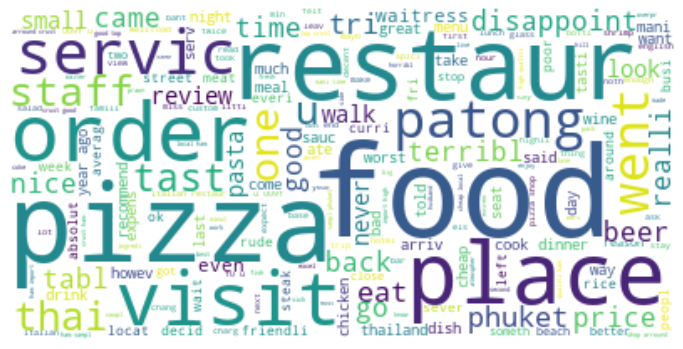

In [43]:
# Wordcloud of words from Negative reviews by hotel/restaurant

neg_tokens = [word for review in reviews_negative_subset['processed_review'] for word in review]
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(neg_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

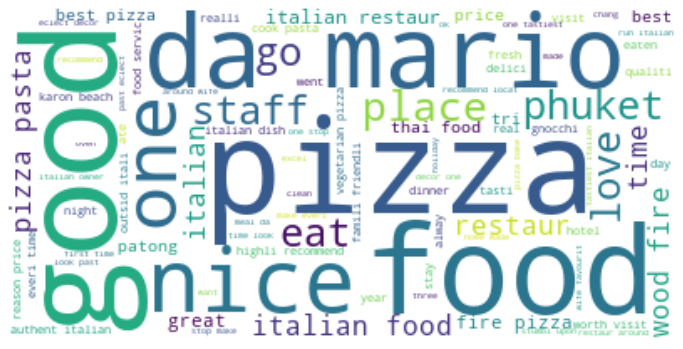

In [22]:
# Wordcloud of words from Positive reviews by hotel/restaurant

pos_tokens = [word for review in reviews_positive_subset['processed_review'] for word in review]
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(pos_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# using nltk FreqDist and then tabulate - for positive reviews
from nltk.probability import FreqDist

pos_freqdist = FreqDist(pos_tokens)
pos_freqdist.tabulate(10)

  pizza italian    food    good restaur   great    nice   place   pasta     one 
    166     130     125      97      88      74      58      57      56      53 


In [24]:
# using nltk FreqDist and then tabulate - for negative reviews
neg_freqdist = FreqDist(neg_tokens)
neg_freqdist.tabulate(10)

  pizza italian restaur    food     ham       u     get    time   crust qualiti 
     42      24      24      23      18      18      13      13      12      12 


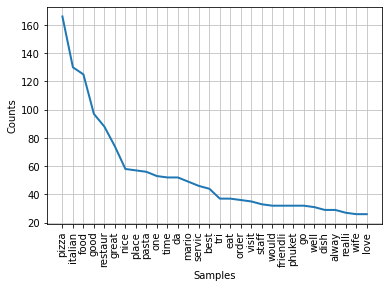

In [25]:
pos_freqdist.plot(35)

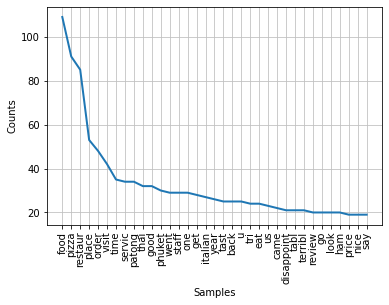

In [45]:
neg_freqdist.plot(35)

### Further Analysis

### => **Analysis based 30 Hotel/Restaurant Locations**

In [27]:
# To determine the number of reviews per Location for the 30 hotels selected
reviews.groupby("Location")['Review'].count()

Location
 Cape Panwa       100
 Chalong          200
 Choeng Thale     200
 Kamala           100
 Karon            192
 Kata Beach       393
 Kathu            200
 Mai Khao         100
 Patong          1787
 Phuket Town      198
 Rawai            196
Name: Review, dtype: int64

In [28]:
# To determine the number of negative reviews per Location for the 30 hotels selected
(reviews['compound']<=0).groupby(reviews['Location']).sum()

Location
 Cape Panwa       12
 Chalong          22
 Choeng Thale     21
 Kamala            2
 Karon            24
 Kata Beach       61
 Kathu            29
 Mai Khao         15
 Patong          223
 Phuket Town      40
 Rawai            18
Name: compound, dtype: int64

In [29]:
# Calculating the negative reviews as a percentage of total reviews per hotel/restaurant location
percent_negative = pd.DataFrame((reviews['compound']<=0).groupby(reviews['Location']).sum()
                                /reviews['Location'].groupby(reviews['Location']).count()*100,
                                columns=['% negative reviews']).sort_values(by='% negative reviews')
percent_negative

,% negative reviews
Location,
Kamala,2.000000
Rawai,9.183673
Choeng Thale,10.500000
Chalong,11.000000
Cape Panwa,12.000000
Patong,12.479015
Karon,12.500000
Kathu,14.500000
Mai Khao,15.000000


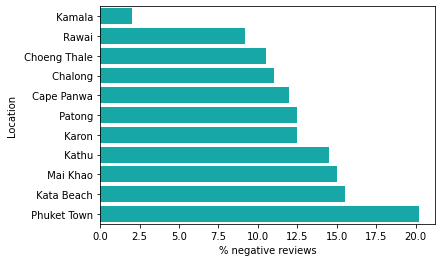

In [30]:
# Plotting the percentage of negative reviews
sns.barplot(data=percent_negative, x='% negative reviews', y=percent_negative.index, color='c')

**'Phuket Town'** Location has hotels/restaurants with the highest percentage of negative reviews, hence it would be the focus of this analysis

In [31]:
# Processing the 'Review' for wordcloud visualisation
# 'Patong Town' Location has hotels with the highest number of reviews, hence it would be the focus of this analysis

reviews['processed_review'] = reviews['Review'].apply(preprocess_text)

reviews_positive_subset = reviews.loc[(reviews['Location'] ==' Patong') & (reviews['compound']>0),:]
reviews_negative_subset = reviews.loc[(reviews['Location'] ==' Patong') & (reviews['compound']<=0),:]


In [32]:
reviews_positive_subset.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos,processed_review
22700,rn581031356,Reviewed 2 days ago,Patong,Sabai Sabai,"In 1997, we were told of this place which is v...",0.6361,0.000,0.890,0.110,"[1997, told, place, popular, australian, next,..."
22701,rn578227936,Reviewed 2 weeks ago,Patong,Sabai Sabai,It was kind tough to get here with the other d...,0.7269,0.098,0.711,0.191,"[kind, tough, get, dude, street, tri, lure, re..."
22702,rn570916360,"Reviewed April 3, 2018",Patong,Sabai Sabai,Small restaurant in Patong beach. Owner not ve...,0.3595,0.000,0.878,0.122,"[small, restaur, patong, beach, owner, freindl..."
22704,rn565380733,"Reviewed March 8, 2018",Patong,Sabai Sabai,This restaurant is very small and looks nothin...,0.9643,0.000,0.612,0.388,"[restaur, small, look, noth, food, great, peop..."
22705,rn565217353,"Reviewed March 8, 2018",Patong,Sabai Sabai,This small restaurant is very close to the bea...,0.5413,0.071,0.745,0.184,"[small, restaur, close, beach, fantast, thai, ..."


In [33]:
reviews_negative_subset.head()

,ID,Review Date,Location,Hotel/Restaurant name,Review,compound,neg,neu,pos,processed_review
22703,rn568306901,"Reviewed March 23, 2018",Patong,Sabai Sabai,I went here on my holiday upon recommendation ...,-0.6441,0.149,0.793,0.058,"[went, holiday, upon, recommend, read, review,..."
22707,rn561716391,"Reviewed February 20, 2018",Patong,Sabai Sabai,Walked in to get a table and was told really r...,-0.3826,0.119,0.816,0.065,"[walk, get, tabl, told, realli, rudley, wait, ..."
22713,rn559503412,"Reviewed February 9, 2018",Patong,Sabai Sabai,Large portions here too much really\r\nSmall p...,-0.3786,0.109,0.835,0.056,"[larg, portion, much, realli, small, place, bu..."
22730,rn547750248,"Reviewed December 17, 2017",Patong,Sabai Sabai,At here everyday for breakfast while on vacati...,-0.0258,0.079,0.825,0.096,"[everyday, breakfast, vacat, food, great, espe..."
22736,rn539304598,"Reviewed November 7, 2017",Patong,Sabai Sabai,An OK restaurant. The food was OK but not mind...,-0.4687,0.231,0.617,0.152,"[ok, restaur, food, ok, mindblow, servic, real..."


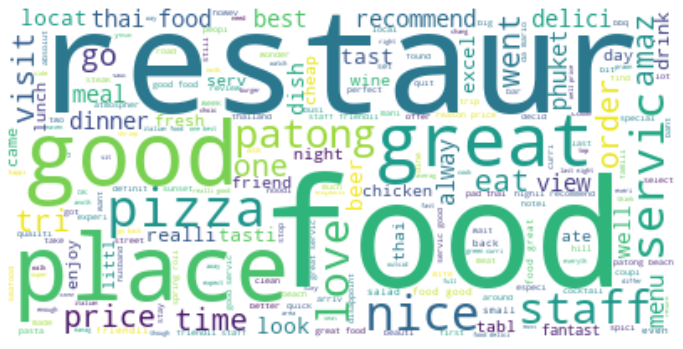

In [34]:
# Wordcloud of words from Positive reviews by hotel/restaurant

pos_tokens = [word for review in reviews_positive_subset['processed_review'] for word in review]
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(pos_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
# using the nltk FreqDist and then tabulate - for positive reviews
pos_freqdist = FreqDist(pos_tokens)
pos_freqdist.tabulate(10)

   food    good restaur   great   place  servic   pizza   staff    thai   price 
   1007     667     532     505     420     377     327     307     304     296 


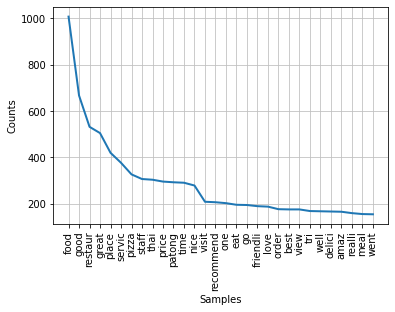

In [37]:
pos_freqdist.plot(30)

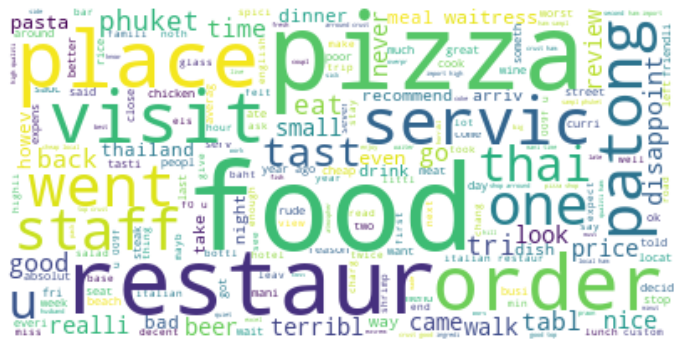

In [35]:
# Wordcloud of words from Negative reviews by hotel/restaurant

neg_tokens = [word for review in reviews_negative_subset['processed_review'] for word in review]
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(neg_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
# using the nltk FreqDist and then tabulate - for negative reviews
neg_freqdist = FreqDist(neg_tokens)
neg_freqdist.tabulate(10)

   food   pizza restaur   place   order   visit    time  servic  patong    thai 
    109      91      85      53      48      42      35      34      34      32 


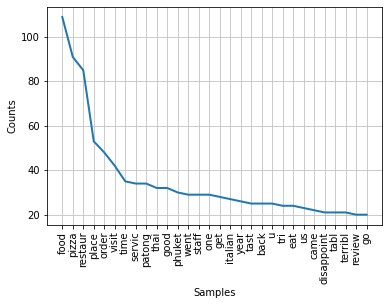

In [39]:
neg_freqdist.plot(30)